### Spacy
It is a framework that performs index preserving tokenization in action -  preserves this “link” between the word and its place in the raw text. It converts the tokens each of length 300.The spacy Pre-trained word vectors are used.

#### Run the following to download the packages

In [0]:
import nltk
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')

#### Run the following to load performance metrics

In [0]:
# pip install keras-metrics

In [3]:
### Required Libraries
import spacy.cli
import pandas as pd
import os, sys
import warnings
import keras_metrics
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression

from nltk import word_tokenize
from nltk.corpus import stopwords
from string import punctuation
from nltk.collocations import *
from nltk.stem import WordNetLemmatizer

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
# spacy.cli.download("en_core_web_lg")

Using TensorFlow backend.


#### Spacy to pre_trained vocabulary set, download and load it


In [0]:
# spacy.cli.download("en_core_web_lg")
nlp = spacy.load('en_core_web_lg')

#### Load the dataset from the csv files
* Training : P1_training_set.csv
* Testing : P1_testing_set.csv


Create a collective dataset (df) - to perform pre-processing uniformly on the dataset

In [0]:
df_train_org = pd.read_csv("P1_training_set.csv")
df_train_shuf = shuffle(df_train_org)

df_test_org = pd.read_csv("P1_testing_set.csv")
df_test_shuf = shuffle(df_test_org)

frames = [df_train_shuf, df_test_shuf]
df = pd.concat(frames, axis=0)

### Preprocessing
- Word Tokenize : Convert the sentences into Tokens
- Use the stopwords and punctuation list from nltk to clean the word tokens
- Use WordNetLemmatizer to convert words to their base form

In [0]:
def preprocessing(text):
    sent = ''.join(i for i in text if not i.isdigit())
    word_sent = word_tokenize(sent)
    _stopwords = set(stopwords.words('english') + list(punctuation))
    st = WordNetLemmatizer() 
    _stopwords.add("'s")
    word_sent = [st.lemmatize(word) for word in word_sent if word not in _stopwords]
    return word_sent

for i in df:
    df['process_E1'] = [preprocessing(i) for i in df['Event 1']]
    df['process_E2'] = [preprocessing(i) for i in df['Event 2']]

### Spacy word Embedding
* Convert the words into vectors each of length 300

In [0]:
import numpy as np
list_E1 = []
for j in df['process_E1']:
  res = [0] * 300
  val = [0] * 300
  length = len(j)
  for token in j:
    res  = res + (nlp.vocab[token].vector)
  val = res/length 
  list_E1.append(val)

import numpy as np
list_E2 = []
for j in df['process_E2']:
  res = [0] * 300
  val = [0] * 300
  length = len(j)
  for token in j:
    res  = res + (nlp.vocab[token].vector)
  val = res/length 
  list_E2.append(val)  
  
event_concat = list(map(lambda x, y: list(x) + list(y), list_E1, list_E2))
df_vec = pd.DataFrame(list(zip(list_E1, list_E2, event_concat, df['Label'])),columns = ['List_E1', 'List_E2', 'Total Event','Label'])


### Input and Output Dataset
* df_vec['Total Event'] - X : Input
* df_vec['Label'] - Y : Output
* Training : 70% of the Dataset
* Testing : 30% of the Dataset

In [0]:
X = df_vec['Total Event']
y = df_vec['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.30, random_state=42)					 
X_train = sequence.pad_sequences(X_train)
X_test = sequence.pad_sequences(X_test)

### Model 1
- Sequential Model
- 100 units - LSTM
- Dense Layer - 1 hidden unit with "sigmoid" activation function
- Dense Layer - 1 hidden unit with "softmax" activation function
- Optimizer - "rmsprop"

In [9]:
model1 = Sequential()
model1.add(Embedding(10000, 500, input_length=600))
model1.add(LSTM(100))
model1.add(Dense(1, activation='sigmoid'))
model1.add(Dense(1, activation="softmax"))
model1.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy', keras_metrics.precision(), keras_metrics.recall()])

print(model1.summary())

# Training Phase - Fit the model
model1.fit(X_train, y_train, epochs=3, batch_size=64)

# Testing Phase - Evaluate the model
scores = model1.evaluate(X_test, y_test, verbose=0)

# Performance Metrics
print('Accuracy   : {:2.3}'.format(scores[1]))
print('Precision  : {:2.3}'.format(scores[2]))
print('Recall     : {:2.3}'.format(scores[3]))
print('Loss       : {:2.3}'.format(scores[0]))
f_score = (2.0 * scores[2] * scores[3]) / (scores[2] + scores[3])
print('F1-Score   : {:2.3}'.format(f_score))






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 600, 500)          5000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               240400    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 2         
Total params: 5,240,503
Trainable params: 5,240,503
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/3
6276/6276 [==============================] - 117s 19ms/step - loss: -2.6240 - acc: 0.3985 - precision: 1.1646 - recall: 1.0000


### Model 2
- Sequential Model
- 100 units - LSTM
- Dense Layer - 256 hidden unit with - "relu" activation function
- Dense Layer - 1 hidden unit with - - "softmax" activation function
- Optimizer - "adam"

In [10]:
model2 = Sequential()
model2.add(Embedding(10000, 500, input_length=600
                     ))
model2.add(LSTM(100))
model2.add(Dense(256, activation='relu'))
model2.add(Dense(1, activation="softmax"))
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', keras_metrics.precision(), keras_metrics.recall()])

print(model2.summary())
model2.fit(X_train, y_train, epochs=3, batch_size=64)

# Final evaluation of the model
scores = model2.evaluate(X_test, y_test, verbose=0)

print('Accuracy   : {:2.3}'.format(scores[1]))
print('Precision  : {:2.3}'.format(scores[2]))
print('Recall     : {:2.3}'.format(scores[3]))
print('Loss       : {:2.3}'.format(scores[0]))
f_score = (2.0 * scores[2] * scores[3]) / (scores[2] + scores[3])
print('F1-Score   : {:2.3}'.format(f_score))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 600, 500)          5000000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               240400    
_________________________________________________________________
dense_3 (Dense)              (None, 256)               25856     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 5,266,513
Trainable params: 5,266,513
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/3
6276/6276 [==============================] - 117s 19ms/step - loss: -2.6240 - acc: 0.3985 - precision: 1.1646 - recall: 1.0000
Epoch 2/3
6276/6276 [==============================] - 116s 19ms/step - loss: -2.6240 - acc: 0.3985 

### Model 3 - Logistic Regression
* Random state - 0
* Solver - 'lbfgs' - limited memory optimization algorithm
* Multi-class

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


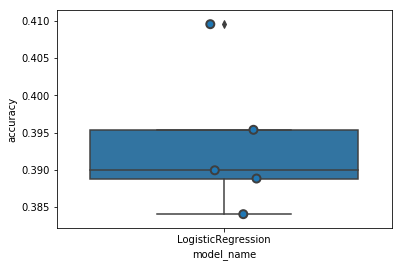

In [11]:
models = [LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial')]
CV = 5
cv_df = pd.DataFrame(index=range(len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()


In [12]:
val = 0
for i in range(len(cv_df)):
  val  = val + cv_df['accuracy'][i]
val = val/5
print("---------------------")
print(cv_df['model_name'][i],'  Accuracy : {:2.3}%'.format(val* 100))
print('---------------------')

---------------------
LogisticRegression   Accuracy : 39.4%
---------------------


### Performance Measure
#### Google Colabs - GPU

#### Model 1 - Sequential - LSTM(100),Sigmod(1), Softmax(1)
* Accuracy   : 40.4%
* Precision  : 1.16
* Recall     : 1.0
* Loss       : -2.49
* F1-Score   : 1.07
##### Computation Time: 6 mins

#### Model 2 - Sequential - LSTM(100),Relu(256), Softmax(1)
* Accuracy   : 40.4%
* Precision  : 1.16
* Recall     : 1.0
* Loss       : -2.49
* F1-Score   : 1.07
##### Computation Time: 6 mins

#### Model 3 - Logistic Regression
* Accuracy : 39.4%